# Exploratory Data Analysis of HRRR Weather Data

**Objective:** This notebook provides an in-depth exploratory data analysis (EDA) of the High-Resolution Rapid Refresh (HRRR) weather data for the Southern California region. The data has been pre-processed into NetCDF files, with each file containing hourly data for a specific year.

**Audience:** This analysis is intended for non-technical stakeholders who are interested in understanding the general weather patterns and characteristics of the region as captured by the HRRR model.

**Methodology:** We will use a single year of data (2024) as a representative sample for this analysis. We will explore the data through three main lenses:
1.  **Executive Summary:** A high-level overview of the dataset's structure and contents.
2.  **Time Series Analysis:** Examining how key weather variables change over time.
3.  **Geospatial Analysis:** Visualizing the spatial distribution of these variables across Southern California.

### 1. Setup and Dependencies

Before we begin our analysis, we need to set up our environment. This involves installing any necessary libraries that are not already part of the project's standard environment and then importing all the tools we'll need for data manipulation, analysis, and visualization.

For our geospatial visualizations, we will use the `cartopy` and `geopandas` libraries. The following command will install them if they are not already available.

In [1]:
%pip install cartopy geopandas

import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

print("Libraries installed and imported successfully!")

Note: you may need to restart the kernel to use updated packages.
Libraries installed and imported successfully!


### 2. Data Loading

Now, let's load our data. We will start by analyzing the data for the year 2024. We use the `xarray` library, which is specifically designed to handle multi-dimensional data like our NetCDF files. This allows us to efficiently load and manipulate the data.

In [2]:
data_path = '../../data/processed/HRRR/hrrr_socal_hourly_2024.nc'
ds = xr.open_dataset(data_path)

# Load the Santiago Fire perimeter GeoJSON
santiago_gdf = gpd.read_file('../../data/santiago.geojson')

# Display the dataset summary
ds

<xarray.Dataset> Size: 1GB
Dimensions:            (time: 366, y: 318, x: 330)
Coordinates:
  * time               (time) datetime64[ns] 3kB 2024-01-01T21:00:00 ... 2024...
    step               timedelta64[ns] 8B ...
    heightAboveGround  float64 8B ...
    latitude           (y, x) float64 840kB ...
    longitude          (y, x) float64 840kB ...
    valid_time         datetime64[ns] 8B ...
    surface            float64 8B ...
Dimensions without coordinates: y, x
Data variables:
    t2m                (time, y, x) float32 154MB ...
    sh2                (time, y, x) float32 154MB ...
    d2m                (time, y, x) float32 154MB ...
    r2                 (time, y, x) float32 154MB ...
    u10                (time, y, x) float32 154MB ...
    v10                (time, y, x) float32 154MB ...
    max_10si           (time, y, x) float32 154MB ...
    prate              (time, y, x) float32 154MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-07-29T11:12 GRIB to CDM+CF via cfgrib-0.9.1...

### 3. Executive Summary of the Data

The output above provides a snapshot of our dataset. Here’s what it tells us:

*   **Dimensions:** These are the fundamental axes of our data. We have `time` (hourly snapshots), `y` (north-south grid points), and `x` (east-west grid points).
*   **Coordinates:** These are the labels for our dimensions. `time` gives us the specific date and hour, while `latitude` and `longitude` correspond to the `y` and `x` grid points, giving them real-world meaning.
*   **Data Variables:** These are the actual weather measurements we are interested in. The list includes:
    *   `t2m`: Temperature at 2 meters above the ground (in Kelvin).
    *   `sh2`: Specific humidity at 2 meters.
    *   `d2m`: Dew point temperature at 2 meters.
    *   `r2`: Relative humidity at 2 meters.
    *   `u10`: East-west component of wind at 10 meters.
    *   `v10`: North-south component of wind at 10 meters.
    *   `prate`: Surface precipitation rate.
    *   `max_10si`: Max wind speed at 10 meters.

### 4. Time Series Analysis

To understand how the weather changes over the year, we can look at the average value of key variables across the entire Southern California region for each hour. This smooths out local variations and reveals the broader temporal trends.

We will look at:
1.  **2m Temperature:** To see the seasonal and daily temperature cycles.
2.  **10m Wind Speed:** To identify periods of high or low wind activity.
3.  **2m Relative Humidity:** To understand moisture patterns.

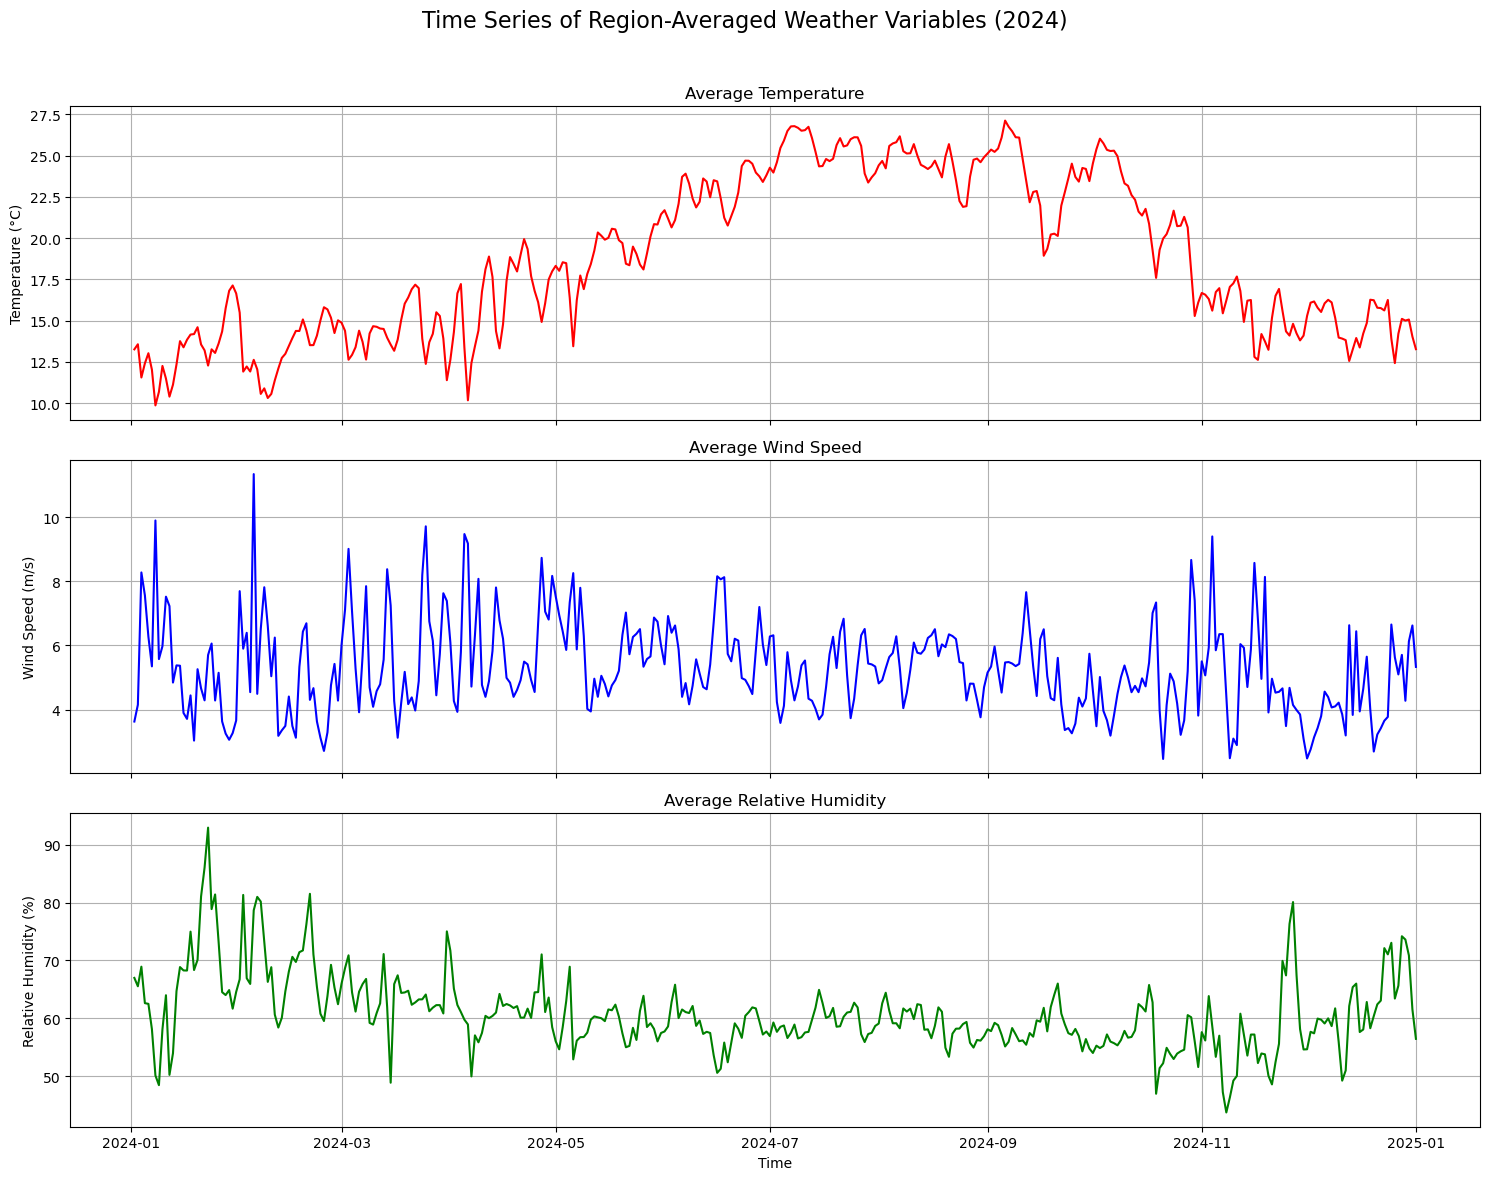

In [3]:
# Calculate spatial mean for key variables
temp_series = ds['t2m'].mean(dim=['x', 'y'])
wind_series = ds['max_10si'].mean(dim=['x', 'y'])
humidity_series = ds['r2'].mean(dim=['x', 'y'])

# Convert temperature from Kelvin to Celsius for easier interpretation
temp_series_celsius = temp_series - 273.15

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 12), sharex=True)
fig.suptitle('Time Series of Region-Averaged Weather Variables (2024)', fontsize=16)

# Temperature Plot
axes[0].plot(ds['time'], temp_series_celsius, label='2m Temperature', color='r')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Average Temperature')
axes[0].grid(True)

# Wind Speed Plot
axes[1].plot(ds['time'], wind_series, label='10m Wind Speed', color='b')
axes[1].set_ylabel('Wind Speed (m/s)')
axes[1].set_title('Average Wind Speed')
axes[1].grid(True)

# Humidity Plot
axes[2].plot(ds['time'], humidity_series, label='2m Relative Humidity', color='g')
axes[2].set_ylabel('Relative Humidity (%)')
axes[2].set_title('Average Relative Humidity')
axes[2].set_xlabel('Time')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Interpretation:**
The plots above show the heartbeat of the region's weather over 2024. We can observe the expected seasonal cycles in temperature, with warmer months in the middle of the year. The wind speed and humidity plots reveal the dynamic nature of the atmosphere, with fluctuations that could correspond to specific weather events like storms or Santa Ana winds.

### 5. Geospatial Analysis

While time series plots are great for seeing *when* things change, geospatial maps show us *where* they change. This is crucial for understanding which parts of the region are most affected by different weather phenomena.

We will create a function to plot any given variable on a map of Southern California. We'll then use it to visualize the spatial distribution of temperature, wind speed, and precipitation at 21:00 UTC of 01/01/2024 (1pm local time)

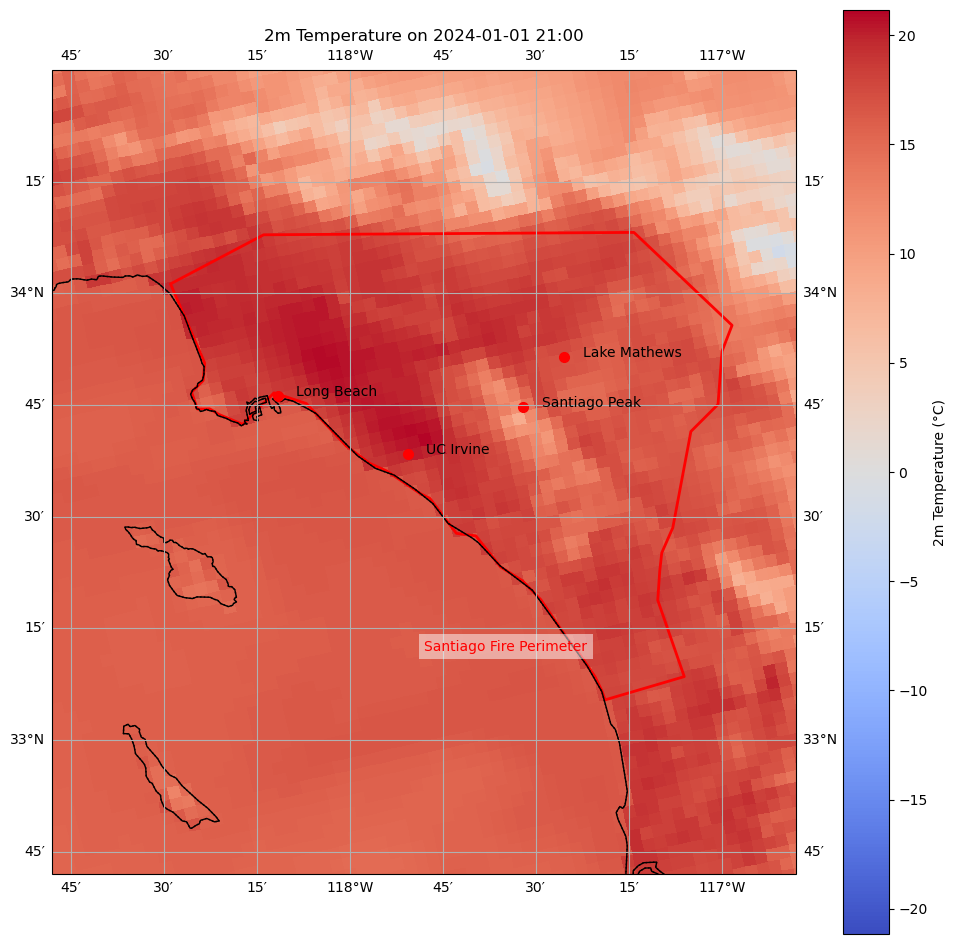

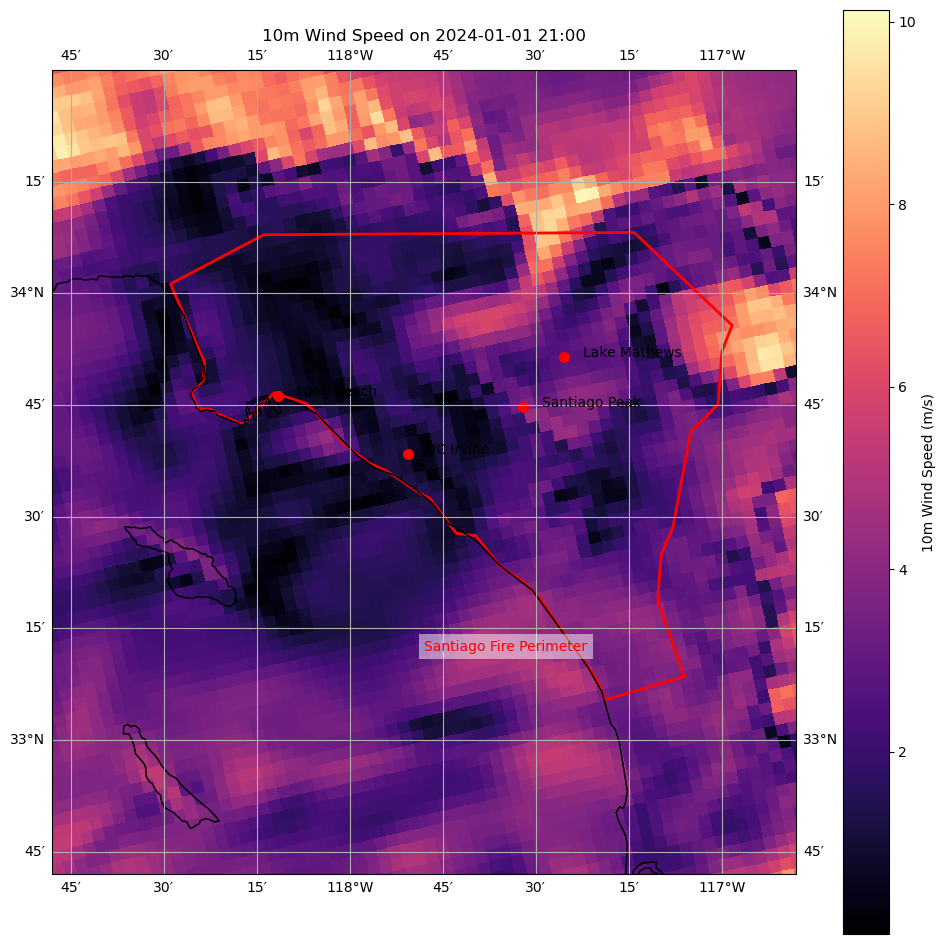

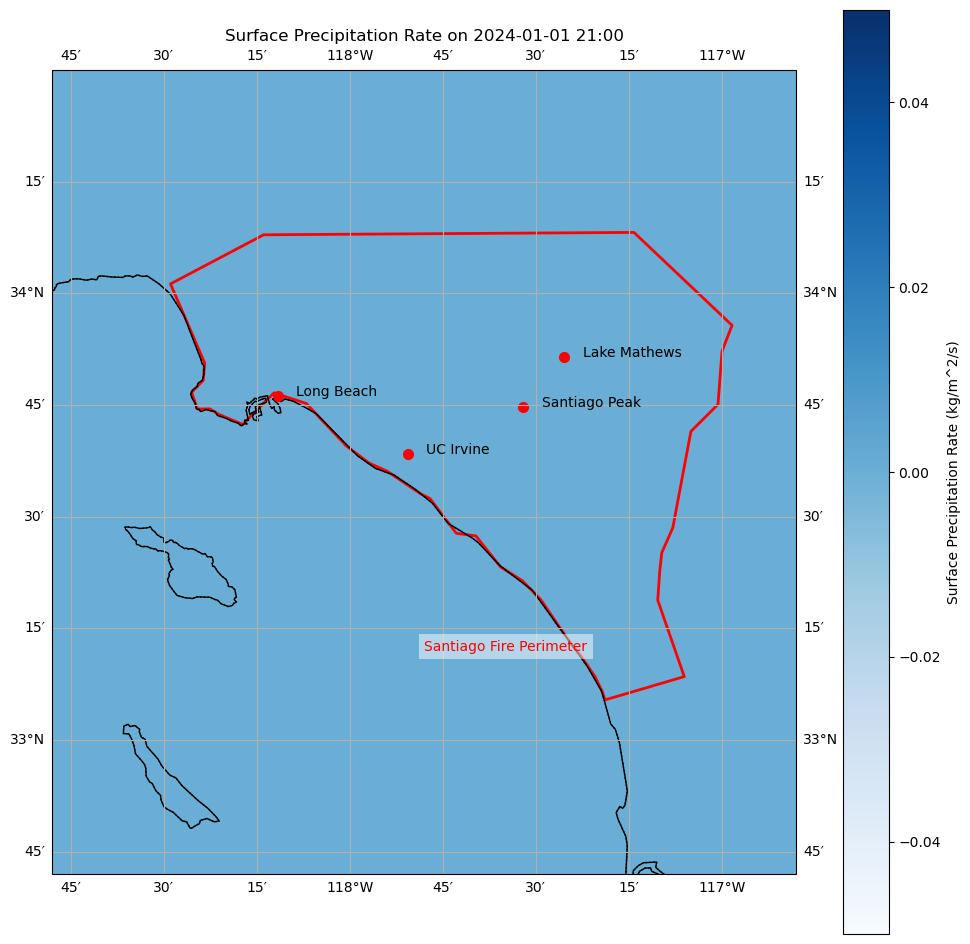

In [4]:
def plot_geospatial(data_array, title, cmap='viridis', unit='', extent=None, points=None, polygon=None):
    """Helper function to plot a 2D data array on a map."""
    plt.figure(figsize=(12, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Set the geographic extent for a focused view
    if extent:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Plot the data
    data_array.plot.pcolormesh(
        ax=ax, 
        x='longitude', 
        y='latitude', 
        transform=ccrs.PlateCarree(), 
        cmap=cmap,
        cbar_kwargs={'label': f'{title} ({unit})'}
    )
    
    # Add geographic features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES, linestyle=':')
    ax.add_feature(cfeature.BORDERS)
    
    # Overlay the polygon
    if polygon is not None:
        polygon.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, transform=ccrs.PlateCarree(), label='Santiago Fire Perimeter')
        ax.text(-117.8, 33.2, 'Santiago Fire Perimeter', transform=ccrs.PlateCarree(), color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Add reference points
    if points:
        for name, (lat, lon) in points.items():
            ax.plot(lon, lat, 'ro', markersize=7, transform=ccrs.PlateCarree())
            ax.text(lon + 0.05, lat, name, transform=ccrs.PlateCarree())
    
    # Set plot title and gridlines
    ax.set_title(f'{title} on {pd.to_datetime(data_array.time.values).strftime("%Y-%m-%d %H:%M")}')
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    
    plt.show()

# Define the extent for the new area [lon_min, lon_max, lat_min, lat_max]
socal_extent = [-118.8, -116.8, 32.7, 34.5]

# Define reference points
reference_points = {
    'Santiago Peak': (33.745, -117.533),
    'Long Beach': (33.770, -118.194),
    'UC Irvine': (33.640, -117.844),
    'Lake Mathews': (33.857, -117.424)
}

# Select the first time step for visualization
first_step = ds.isel(time=0)

# Plot Temperature with the focused extent and points
plot_geospatial(first_step['t2m'] - 273.15, '2m Temperature', cmap='coolwarm', unit='°C', extent=socal_extent, points=reference_points, polygon=santiago_gdf)

# Plot Wind Speed with the focused extent and points
plot_geospatial(first_step['max_10si'], '10m Wind Speed', cmap='magma', unit='m/s', extent=socal_extent, points=reference_points, polygon=santiago_gdf)

# Plot Precipitation Rate with the focused extent and points
plot_geospatial(first_step['prate'], 'Surface Precipitation Rate', cmap='Blues', unit='kg/m^2/s', extent=socal_extent, points=reference_points, polygon=santiago_gdf)

**Interpretation:**
These maps reveal the spatial complexity of the weather in Southern California. We can see how temperature varies between the coast and inland areas, and how wind speeds might be higher in certain mountain passes or valleys. The precipitation map shows where rain might be falling at a given time. These patterns are critical for applications like wildfire risk assessment and resource management.

### 6. Wind Analysis: Speed and Direction

Wind is a critical factor in this region, especially for wildfire behavior. The dataset provides the wind in terms of its east-west (U) and north-south (V) components. To make this more intuitive, we can visualize it as a vector field, showing both the speed and direction of the wind across the map.

The plot below shows wind vectors. The arrows point in the direction the wind is blowing, and their length and color indicate the wind speed.

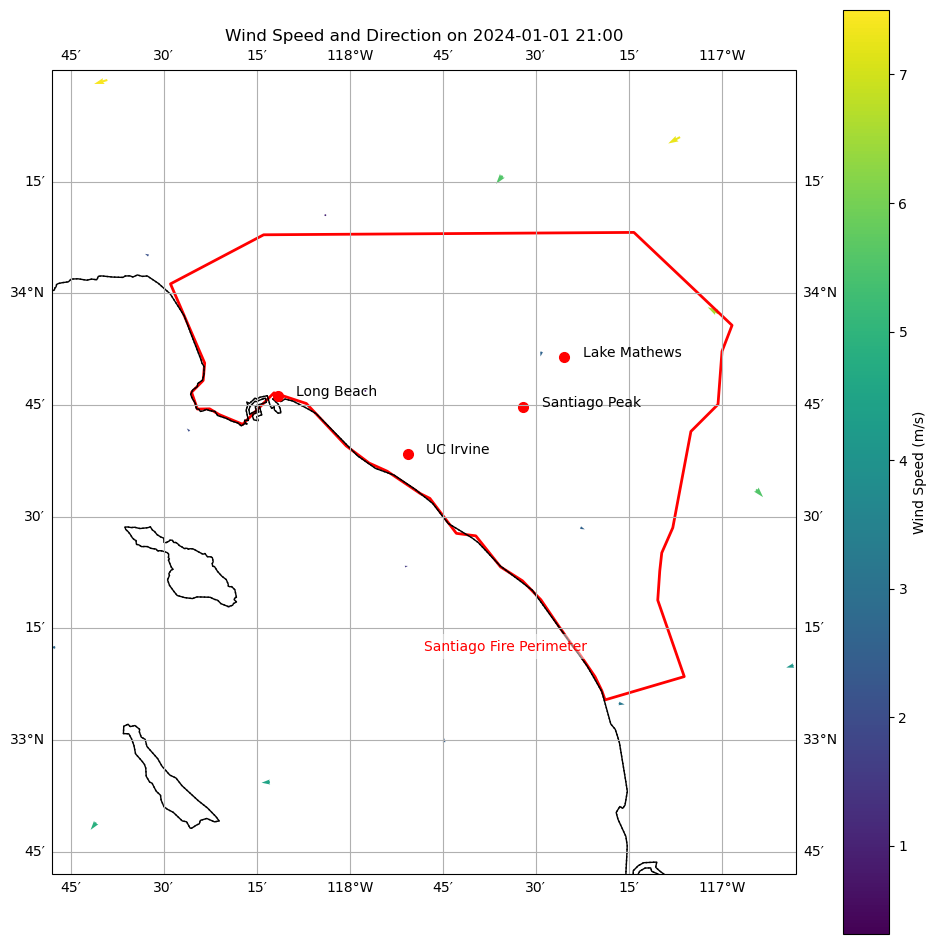

In [5]:
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

# Define the extent and reference points
socal_extent = [-118.8, -116.8, 32.7, 34.5]
reference_points = {
    'Santiago Peak': (33.745, -117.533),
    'Long Beach': (33.770, -118.194),
    'UC Irvine': (33.640, -117.844),
    'Lake Mathews': (33.857, -117.424)
}
ax.set_extent(socal_extent, crs=ccrs.PlateCarree())

# Subsample the data for a clearer plot
subsample = 15
x = first_step['longitude'][::subsample, ::subsample]
y = first_step['latitude'][::subsample, ::subsample]
u = first_step['u10'][::subsample, ::subsample]
v = first_step['v10'][::subsample, ::subsample]
wind_speed = first_step['max_10si'][::subsample, ::subsample]

# Plot wind vectors
quiver = ax.quiver(x, y, u, v, wind_speed, transform=ccrs.PlateCarree(), cmap='viridis', scale=400)
plt.colorbar(quiver, ax=ax, label='Wind Speed (m/s)', orientation='vertical')

# Add geographic features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')
ax.add_feature(cfeature.BORDERS)

# Overlay the polygon
santiago_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, transform=ccrs.PlateCarree())
ax.text(-117.8, 33.2, 'Santiago Fire Perimeter', transform=ccrs.PlateCarree(), color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# Add reference points
for name, (lat, lon) in reference_points.items():
    ax.plot(lon, lat, 'ro', markersize=7, transform=ccrs.PlateCarree())
    ax.text(lon + 0.05, lat, name, transform=ccrs.PlateCarree())

# Set title and gridlines
ax.set_title(f'Wind Speed and Direction on {pd.to_datetime(first_step.time.values).strftime("%Y-%m-%d %H:%M")}')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

plt.show()

### 7. Further Analysis and Next Steps

This notebook has only scratched the surface of what's possible with this rich dataset. Based on this initial exploration, several avenues for deeper analysis emerge:

*   **Diurnal and Seasonal Cycles:** A more formal analysis of daily and seasonal patterns for different variables and locations.
*   **Extreme Events:** Identifying and analyzing periods of extreme weather, such as heatwaves, high winds (e.g., Santa Ana events), or heavy precipitation.
*   **Correlation Analysis:** Investigating the relationships between different variables. For example, how does temperature relate to humidity or wind speed?
*   **Multi-Year Analysis:** Combining all the yearly data files to analyze long-term trends and inter-annual variability.
*   **Wildfire Case Studies:** Focusing on specific time periods and locations of known wildfires to understand the concurrent weather conditions.

### 8. Conclusion

This exploratory data analysis has provided a foundational understanding of the HRRR weather data for Southern California. We have seen how to load, summarize, and visualize this complex dataset to extract meaningful insights about temporal and spatial weather patterns.

The key takeaways are:
*   The dataset is well-structured and contains a rich set of variables crucial for weather and climate analysis.
*   Time series analysis reveals clear seasonal patterns in temperature and dynamic behavior in wind and humidity.
*   Geospatial mapping is essential for understanding the complex, location-dependent nature of weather in this topographically diverse region.

This notebook serves as a starting point and a template for more advanced and targeted analyses to support decision-making in areas like wildfire management, agriculture, and resource planning.